In [1]:
# 준비 

# colab 드라이브 연결하기 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 패키지 불러오기 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objs as go 
import plotly.express as px

# 01. 데이터 준비

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/T20_2019_1백만.1.csv", encoding = "euc-kr")
df2 = pd.read_csv("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/T20_2019_1백만.2.csv", encoding = "euc-kr")
df3 = pd.read_csv("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/T20_2019_1백만.3.csv", encoding = "euc-kr")

In [ ]:
# 데이터 합치기 
df = pd.concat([df1,df2,df3])
del df1, df2, df3

1) 타겟 컬럼 생성 : 입원 여부 

In [ ]:
df['서식코드'].unique()

In [ ]:
# 서식코드를 입원여부로 변환
# 1이면 입원 O, 0이면 입원 X 
df.loc[(df['서식코드']==2), '서식코드'] = 1 
df.loc[(df['서식코드']==3), '서식코드'] = 0
df.loc[(df['서식코드']==8), '서식코드'] = 0 

In [ ]:
# 변환 확인 
df['서식코드'].unique()

In [ ]:
# 컬럼명 변경 
df.rename(columns = {'서식코드' : '입원여부'}, inplace= True)

In [ ]:
# 변경 확인 
df.columns

2) 시도 코드 시도명으로 변환 

In [ ]:
# 시도 데이터 불러오기 
df_sido = pd.read_csv("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/sido.txt", sep = "|")
df_sido.head(2)

In [ ]:
# 시도명 컬럼 추가 
df_sido.columns = ['시도코드', '시도명']
df = pd.merge(df, df_sido, how = 'left', on = '시도코드')
df.head(2)

3) 연령대코드 연령대로 변환 

In [ ]:
df['연령대코드'].unique()

In [ ]:
# 0, 10, 20 ,...,80 대로 변경 
count = 0
age = 80
for i in range(18,0, -1) : 
  if count == 0 : 
    df.loc[(df['연령대코드']==i), '연령대코드'] = str(age) 
    count += 1 
  elif count ==1 : 
    df.loc[(df['연령대코드']==i), '연령대코드'] = str(age) 
    count = 0 
    age -= 10  

4) 진료과목코드 진료과목으로 변환 

In [ ]:
# 진료과목코드 데이터 불러오기 
df_subject = pd.read_excel("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/컬럼정보_코드.xls")
df_subject.head(2)

In [ ]:
# 안쓰는 데이터 컬럼 제거 
df_subject.drop(['코드구분', '설명'], axis = 1 , inplace = True)
df_subject.columns = ['진료과목코드', '진료과목']

In [ ]:
# 컬럼 합치기 
df = pd.merge(df, df_subject, how = 'left', on = '진료과목코드')
df.head(2)

In [ ]:
df.columns

In [ ]:
# 안쓰는 컬럼 삭제 
df.drop(['기준년도','진료내역일련번호','데이터 기준일자','시도코드', '진료과목코드'], axis= 1, inplace = True)

5) 상병코드 변환

In [ ]:
# 앞의 한 글자만 추출 
df['주상병코드'] = df['주상병코드'].str[:1]
df['부상병코드'] = df['부상병코드'].str[:1]

In [ ]:
# 데이터 프레임 저장 
df.to_csv("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/df.csv", index = False)

In [45]:
# df = pd.read_csv("/content/drive/MyDrive/프로젝트/멀티캠퍼스/프로젝트1/df.csv")
# df.drop(['Unnamed: 0','심결본인부담금','심결보험자부담금','가입자 일련번호'], axis = 1, inplace = True)

In [6]:
df.head(2)

,성별코드,연령대코드,입원여부,주상병코드,부상병코드,요양일수,입내원일수,심결가산율,심결요양급여비용총액,총처방일수,시도명,진료과목
0,2,50,0,M,M,1,1,0.25,19240,0,전라남도,정형외과
1,2,50,0,E,N,1,1,0.25,145680,0,전라남도,내과


# 02. 데이터 탐색 및 시각화 (EDA)

3) 시도 별 입원 비율 

In [15]:
# 시도별 입원 여부 회수 데이터프레임 생성 
df_sido = pd.crosstab(index = df['시도명'], columns= df['입원여부'] )
df_sido.reset_index(inplace = True)
df_sido.columns = ['시도명','입원 X', "입원 O"]
df_sido.head()

,시도명,입원 X,입원 O
0,강원도,356466,7928
1,경기도,3143574,57946
2,경상남도,839227,24848
3,경상북도,690849,17174
4,광주시,337543,11748


In [16]:
# 비율 추가 
df_sido['비율O'] = df_sido['입원 O'] / (df_sido['입원 O'] + df_sido['입원 X'])
df_sido['비율X'] = df_sido['입원 X'] / (df_sido['입원 O'] + df_sido['입원 X'])

In [18]:
# 시각화
fig = go.Figure()

fig.add_trace(go.Bar(x = df_sido['시도명'], y = df_sido['비율X'], name = '입원 X'))
fig.add_trace(go.Bar(x = df_sido['시도명'], y = df_sido['비율O'], name = '입원 O'))

fig.update_layout(title = '시도별 입원 여부 비율', xaxis_title = '시도명', yaxis_title = '비율', barmode="stack" )

fig.show()

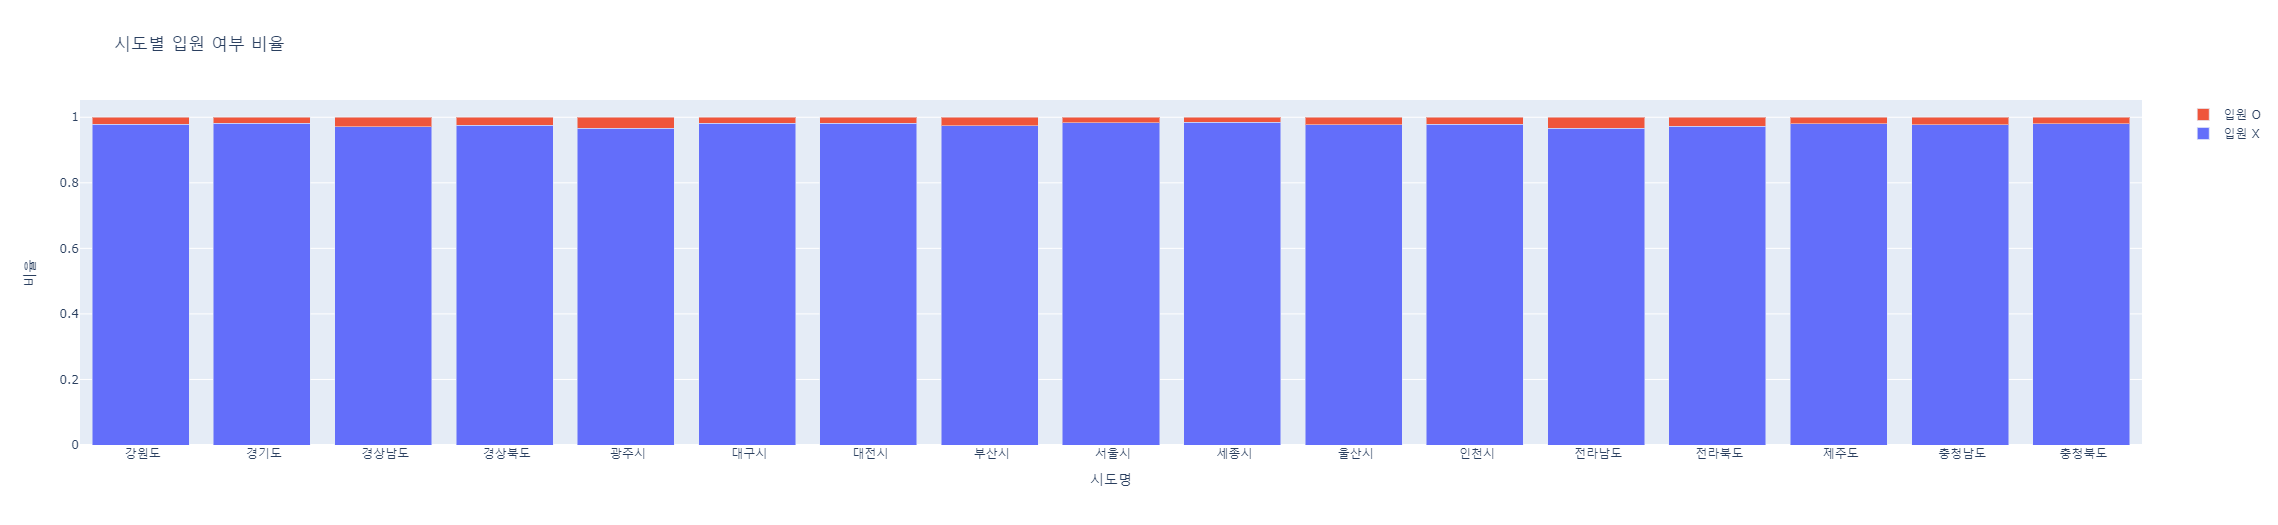

4) 진료과목 별 입원 비율 

In [23]:
df_type = pd.crosstab(index = df['진료과목'], columns= df['입원여부'] )
df_type.reset_index(inplace = True)
df_type.columns = ['진료과목','입원 X', "입원 O"]
df_type.head()

,진료과목,입원 X,입원 O
0,가정의학과,361533,18220
1,결핵과,1017,69
2,구강악안면외과,1,9
3,내과,4319462,68497
4,마취통증의학과,194939,1398


In [24]:
df_type['비율O'] = df_type['입원 O'] / (df_type['입원 O'] + df_type['입원 X'])
df_type['비율X'] = df_type['입원 X'] / (df_type['입원 O'] + df_type['입원 X'])

In [25]:
fig = go.Figure()

fig.add_trace(go.Bar(x = df_type['진료과목'], y = df_type['비율X'], name = '입원 X'))
fig.add_trace(go.Bar(x = df_type['진료과목'], y = df_type['비율O'], name = '입원 O'))

fig.update_layout(title = '진료과목별 입원 여부 비율', xaxis_title = '진료과목명', yaxis_title = '비율', barmode="stack" )

fig.show()

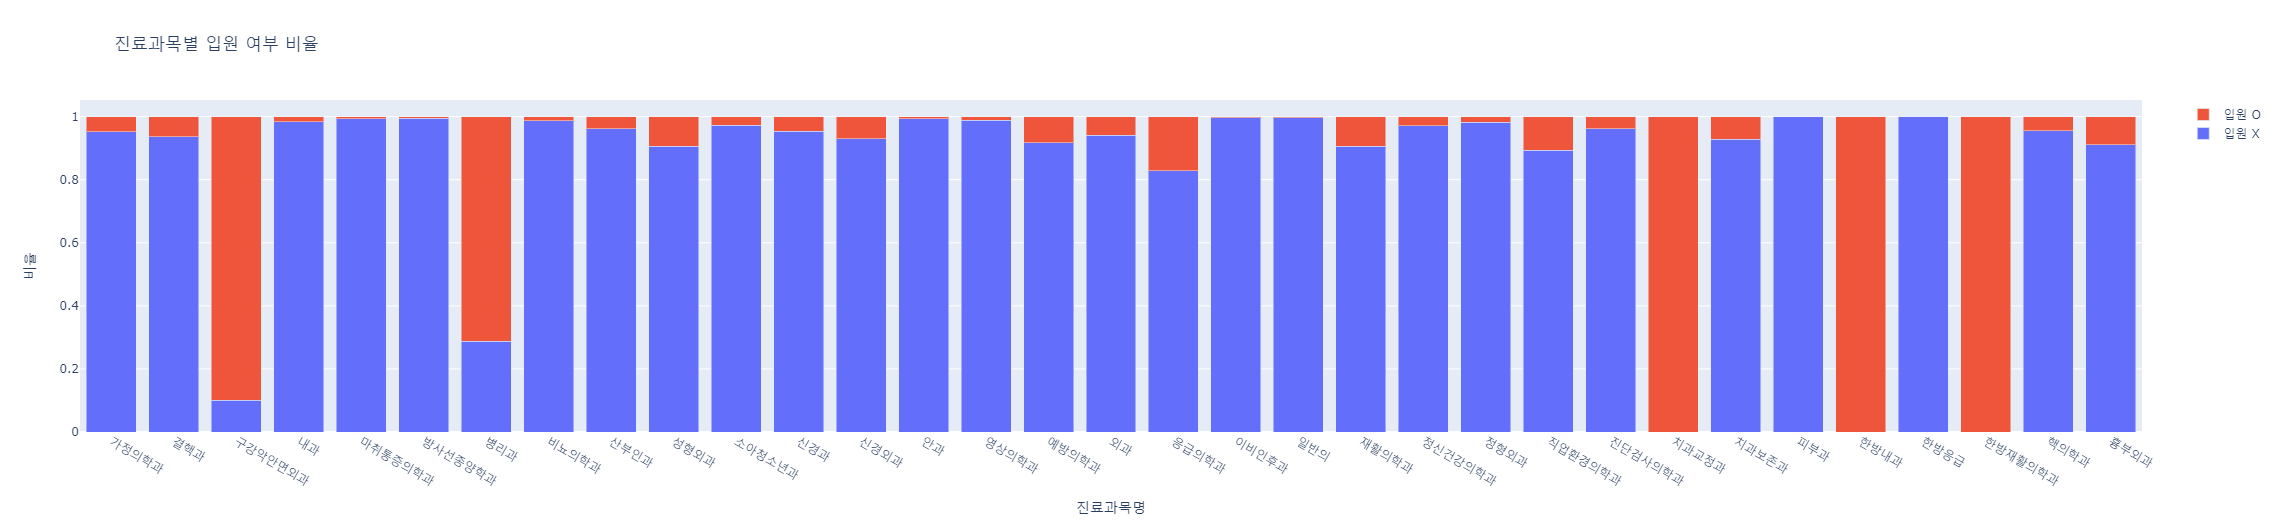

5) 주상병코드 & 부상병코드 

In [31]:
df_code = pd.crosstab(index = [df['주상병코드'],df['부상병코드']], columns= df['입원여부'] )
df_code.reset_index(inplace = True)
df_code.columns = ['주상병코드','부상병코드','입원 X', "입원 O"]
df_code.head()

,주상병코드,부상병코드,입원 X,입원 O
0,A,A,7197,463
1,A,B,4236,127
2,A,C,241,149
3,A,D,646,155
4,A,E,3834,732


In [32]:
df_code['비율O'] = df_code['입원 O'] / (df_code['입원 O'] + df_code['입원 X'])
df_code['비율X'] = df_code['입원 X'] / (df_code['입원 O'] + df_code['입원 X'])

In [51]:
# 주상병코드와 부상병코드 합친 조합 컬럼 생성 
df_code['조합'] = df_code['주상병코드']+df_code['부상병코드']

In [44]:
fig = go.Figure()

fig.add_trace(go.Bar(x = df_code['조합'], y = df_code['비율O'], name = '입원 O'))
fig.add_trace(go.Bar(x = df_code['조합'], y = df_code['비율X'], name = '입원 X'))

fig.update_layout(title = '부상코드별 입원 여부 비율', xaxis_title = '부상코드명', yaxis_title = '비율', barmode="stack" )

fig.show()


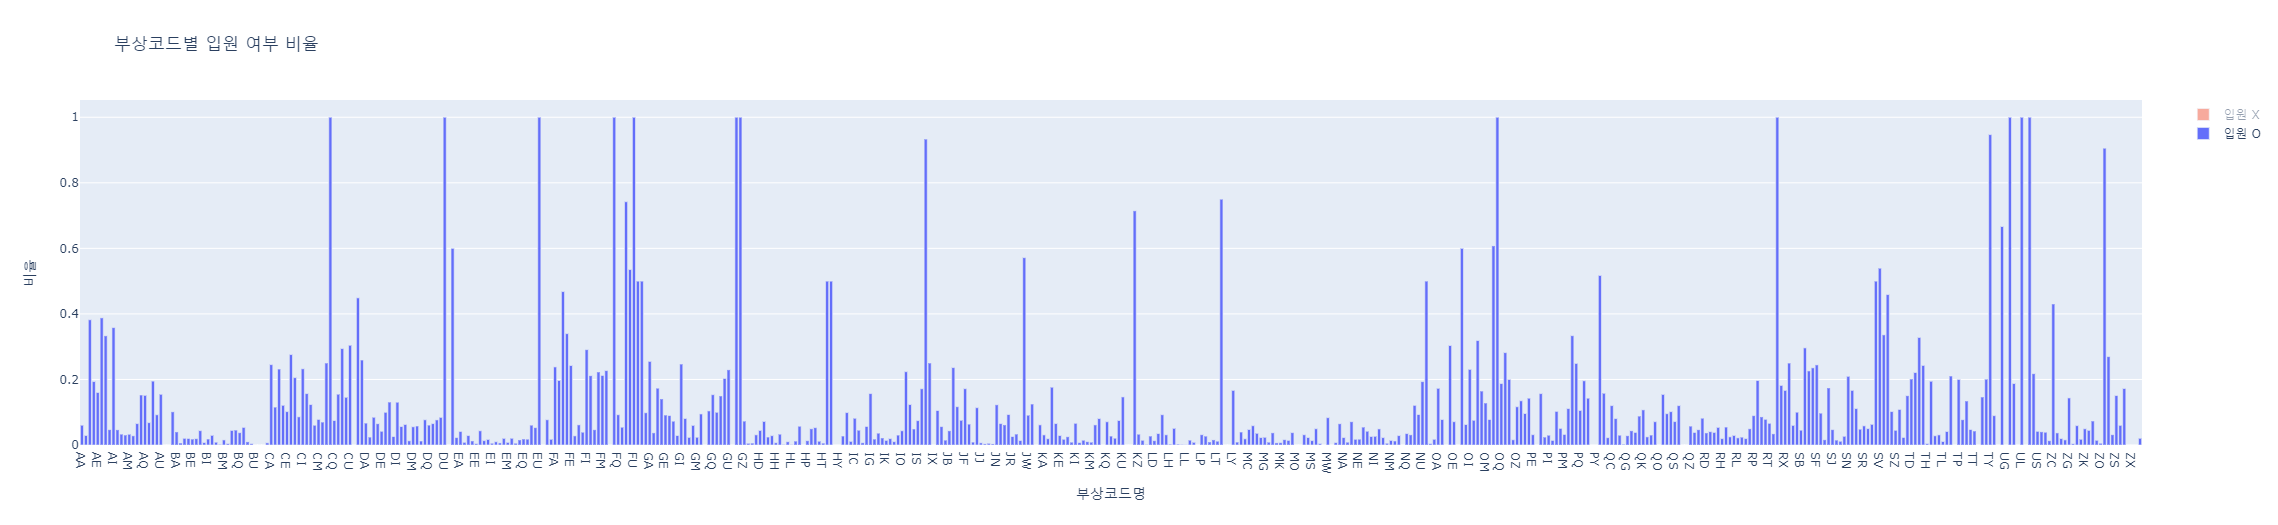

6) 요양개시일자 별 입원 여부 변화 

In [47]:
df_day = pd.crosstab(index = df['요양개시일자'], columns = df['입원여부'])
df_day.reset_index(inplace = True)
df_day.columns = ['요양개시일자','입원 X', "입원 O"]
df_day.head(2)

,요양개시일자,입원 X,입원 O
0,20190101,3934,7198
1,20190102,52798,1009


In [50]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = df_day['요양개시일자'], y = df_day['입원 O'], name = '입원 O'))
# fig.add_trace(go.Bar(x = df_c['조합'], y = df_code['비율X'], name = '입원 X'))

fig.update_layout(title = '일자별 입원 수', xaxis_title = '날짜', yaxis_title = '회수', barmode="stack" )
fig.update_xaxes(type='category')

fig.show()
